# Figure 3- HLA

In [1]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Setup.Read_HIV_Data import *

importing IPython notebook from Setup/Read_HIV_Data

In [3]:
import Setup.DX_Imports as dx

importing IPython notebook from Setup/DX_Imports

Set of patients used in analysis of age advancement

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.2138     0.9326    5.59 1.25e-07 ***
chron_age     0.9790     0.0600   16.32  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.886 on 132 degrees of freedom
Multiple R-squared:  0.6685,	Adjusted R-squared:  0.666 
F-statistic: 266.2 on 1 and 132 DF,  p-value: < 2.2e-16


                2.5 %   97.5 %
(Intercept) 3.3689637 7.058680
chron_age   0.8602881 1.097651



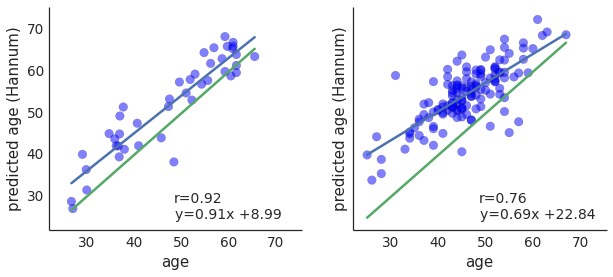

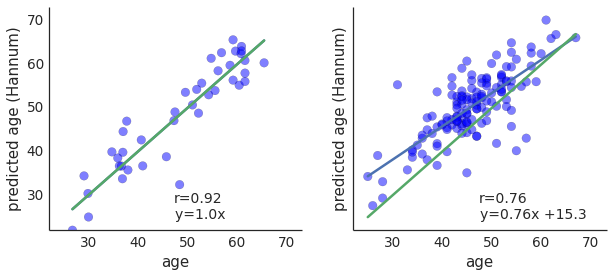

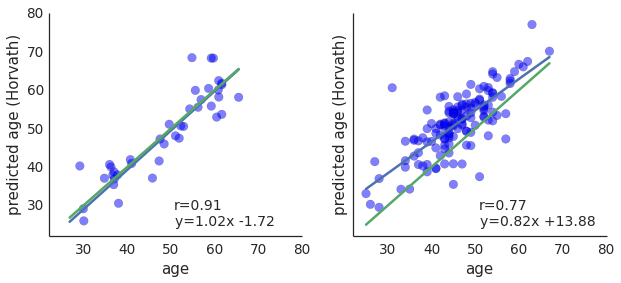

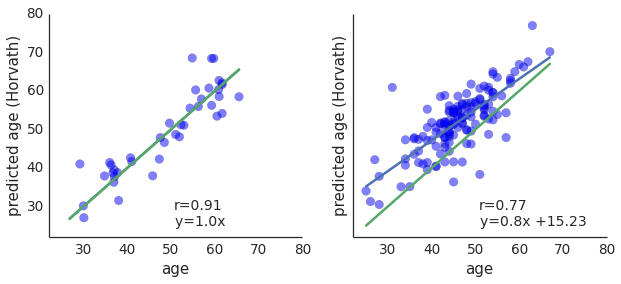

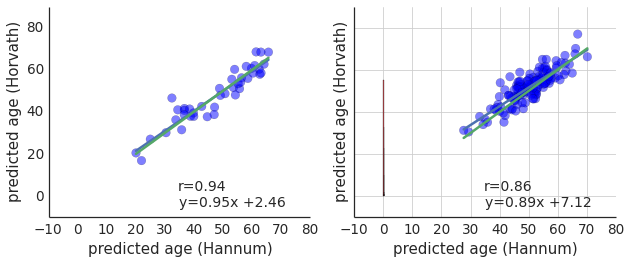

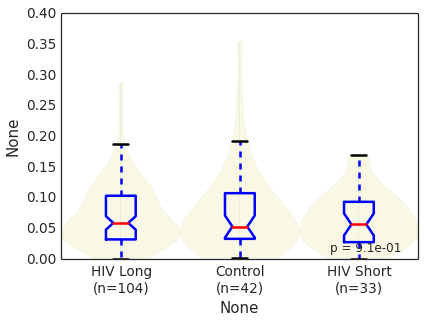

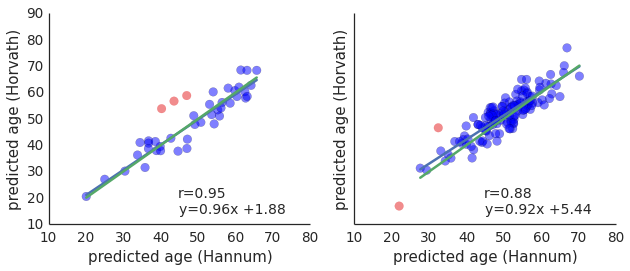

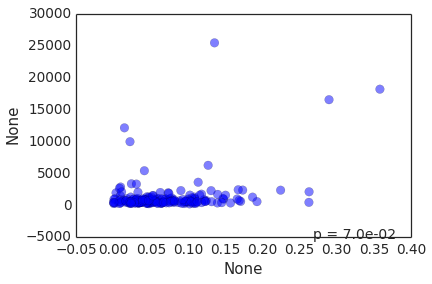

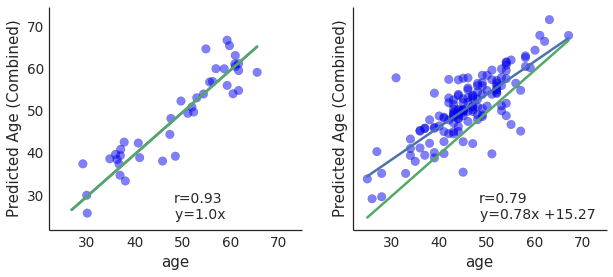

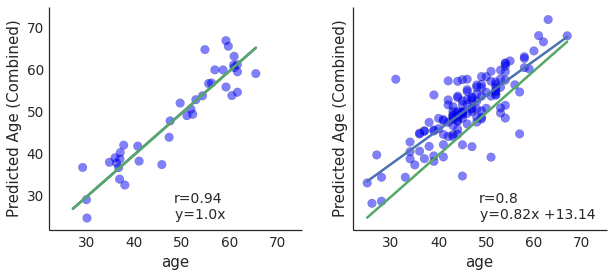

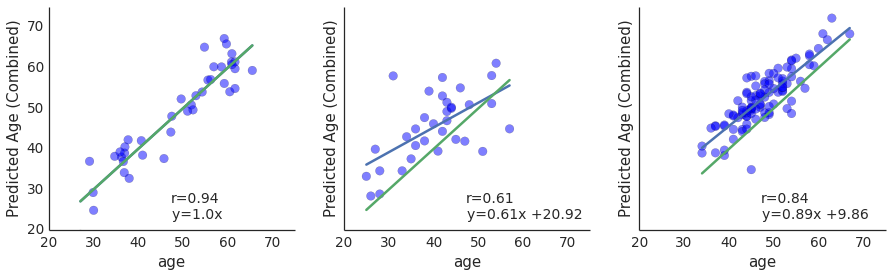

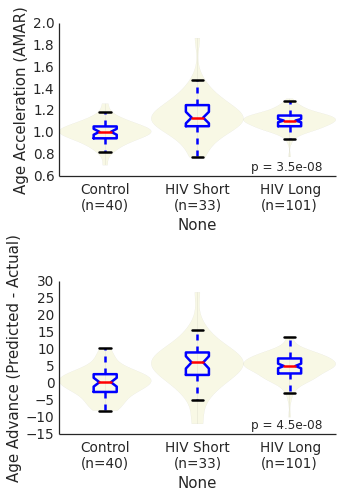

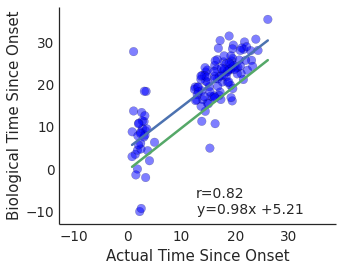

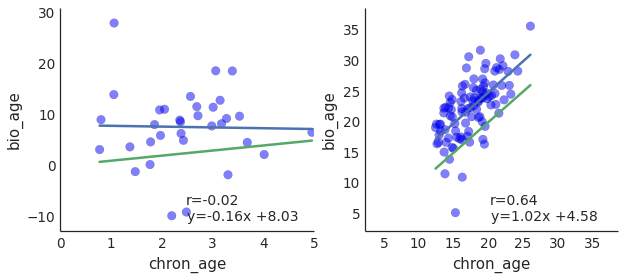

In [4]:
import Parallel.Age_HIV_Features as fx

In [5]:
keepers = fx.pred_c.index

In [6]:
features = {'Age only': fx.features['Age (BH)'],
            'HIV + Age': fx.features['HIV + Age (BH)'],
            'HIV only': fx.features['HIV (BH)']}

probes_sets = {'PRC2': dx.prc2_probes, 'CpG island': dx.cpg_island,
               'DHS': dx.dhs_site, 'Enhancer': dx.enhancer,
               'Gene body': dx.gene_body, 'TSS': dx.gene_tss,
               'Promoter': dx.promoter}

In [7]:
c1 = pd.DataFrame({i:v.value_counts() for i,v in features.iteritems()}).T
c1

,False,True
Age only,451748,21296
HIV + Age,467413,5631
HIV only,397314,75730


In [8]:
c2 = pd.DataFrame({i:v.value_counts() for i,v in probes_sets.iteritems()}).T
c2

,False,True
CpG island,314588,130023
DHS,425596,59916
Enhancer,382953,102559
Gene body,309941,175571
PRC2,406430,79082
Promoter,387422,98090
TSS,345509,140003


In [44]:
ann = dx.probe_annotations.sort(['Chromosome','Genomic_Coordinate'])

In [49]:
a,b = match_series((fx.mm > .5), (fx.r4.multi_variate.HIV < 0))
a,b = match_series(a,b)
direction = a == b

hiv_bh = fx.g_hiv
hiv_bh = (hiv_bh & (direction == False) & (fx.g_age == False)).dropna()
hiv_bh = hiv_bh.ix[probe_idx].ix[ann.index].dropna()
#hiv_bh = hiv_bh & (t_hiv.abs() > 1) 
hiv_bh.value_counts()

False    447553
True      25491
dtype: int64

In [12]:
def manhattan(vec, chrom, coords, ax=None, ybound=None,
              flow='up', ticks=True, gap=3e7):
    fig, ax = init_ax(ax, figsize=(9,3))
    x = 0
    chr_coords = []
    for i,c in enumerate(map(str, range(1,23))):
        v = vec.ix[ti(chrom == c)].dropna()
        series_scatter(coords + x, v, s=10, ax=ax, 
                       color=colors[i % 5], 
                       ann=None, alpha=1, rasterized=True) 
        chr_len = coords.ix[v.index].max()
        x = x + chr_len + gap
        chr_coords += [x - (chr_len / 2.)]
    ax.set_xbound(gap, x + gap)
    if ybound is not None:
        ax.set_ybound(ybound[0],ybound[1])
    ax.set_xlabel('Chromosome')
    
    if ticks:
        ax.set_xticks(chr_coords)
        ax.set_xticklabels(map(str, range(1,23)))
    else:
        ax.set_xticks([])
    top = flow == 'down'
    prettify_ax(ax, top)

In [50]:
m = hiv_bh.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               hiv_bh.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

### Loading in GWAS Data

In [51]:
gwas = pd.read_csv('./data/Euro_CHAVI_Setpoint_liftover.csv', index_col=0)
gwas.chromosome = gwas.chromosome.astype(str)

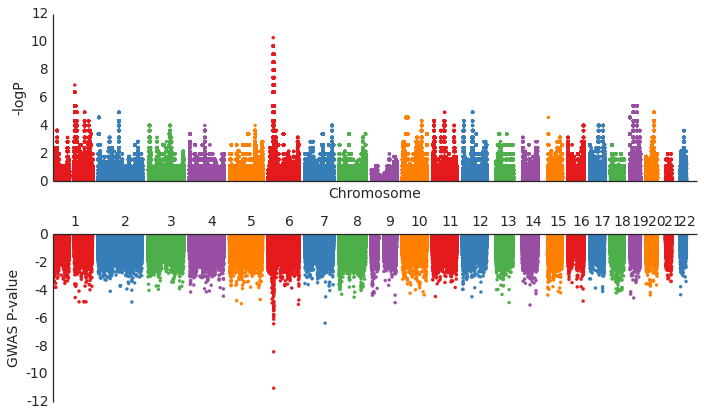

In [52]:
fig, axs = subplots(2,1, figsize=(10, 6))

ax = axs[0]
manhattan(-1*np.log10(biom_p), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,12], ax=ax, ticks=False)

ax.set_yticks(range(0, 13, 2))
#ax.set_yticklabels(range(0, 26, 5), size=14)
ax.set_xlabel('Chromosome', size=14)
axs[0].set_ylabel('-logP',
                  size=14)

ax = axs[1]
manhattan(-1*gwas['-logP'], gwas.chromosome, gwas.Map,
          ybound=[-12,0], ax=ax, flow='down')
ax.set_ylabel('GWAS P-value', size=14)
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_xticklabels(range(1,23), size=14)
ax.set_xlabel('')

fig.tight_layout()
fig.savefig(FIGDIR + 'fig3_cd_n.pdf', dpi=300)

Look for associations with CD4T counts of HIV-associated probes

In [53]:
dm_cell = pd.read_csv('./data/Jaffee_Supplementary_Table_2.csv', index_col=0,
                      low_memory=False, skiprows=[0])

In [54]:
df = df_hiv.ix[ti(hiv_bh.dropna())]
df = df.ix[:, keepers.intersection(ti(fx.hiv == 'HIV+'))]
df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)

In [55]:
corr_with_cd4_m = screen_feature(np.log2(labs['CD4/CD8 ratio']), spearman_pandas, df,
                               align=False)

In [56]:
corr_with_cd4_m.head()

,rho,p,q
cg24351901,0.44,1.53e-07,0
cg06872964,0.42,4.57e-07,0
cg12752647,-0.42,5.41e-07,0
cg15473346,0.42,5.77e-07,0
cg23048215,0.41,1.00e-06,0


In [57]:
rr = (dm_cell.CD4T_mean - dm_cell.CD8T_mean)

In [58]:
spearman_pandas(rr, corr_with_cd4_m.rho)

rho    3.65e-02
p      1.32e-08
dtype: float64

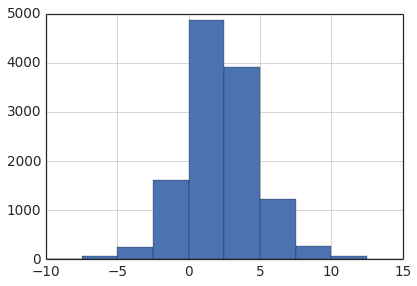

In [23]:
vv = np.log2(corr_with_cd4_m.rho / rr).clip(-10,15).dropna()
vv.hist()

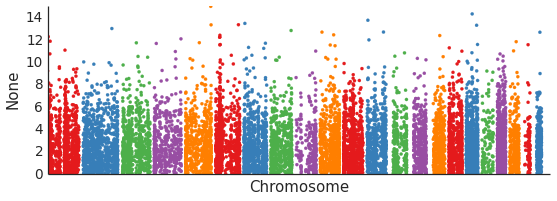

In [24]:
manhattan(vv.abs(), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,15], ticks=False)

In [25]:
dm_cell.ix['cg06872964']

Fstat         6.60e+00
p.value       2.98e-04
CD8T_mean     6.07e-01
CD4T_mean     5.02e-01
NK_mean       6.20e-01
Bcell_mean    5.55e-01
Mono_mean     5.07e-01
Gran_mean     4.73e-01
DNAm_low      4.14e-01
DNAm_high     7.19e-01
DNAm_range    3.05e-01
Name: cg06872964, dtype: float64

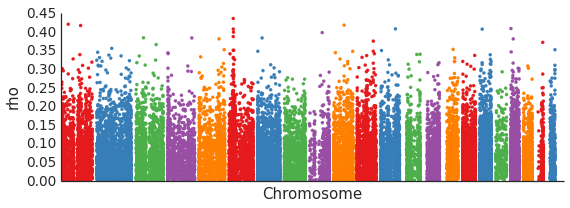

In [26]:
manhattan(corr_with_cd4_m.rho.abs(), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,.45], ticks=False)

In [27]:
ss = -1*np.sign(fx.r4.multi_variate.HIV)

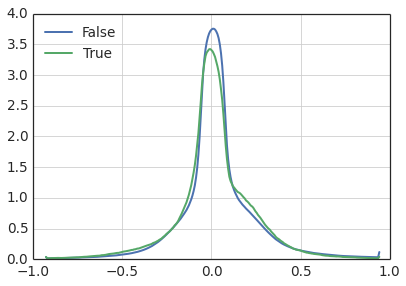

In [28]:
rr = np.log2(dm_cell.CD4T_mean / dm_cell.CD8T_mean).clip(-1.,1.)
draw_dist(rr*ss, hiv_bh)

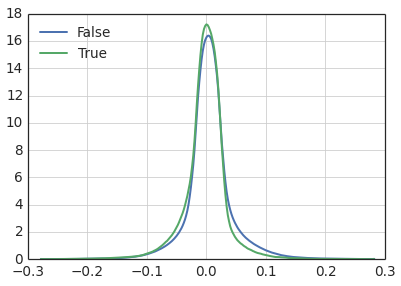

In [63]:
rr = (dm_cell.CD4T_mean - dm_cell.CD8T_mean).clip(-.3,.3)
draw_dist(rr*ss, hiv_bh)

In [64]:
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

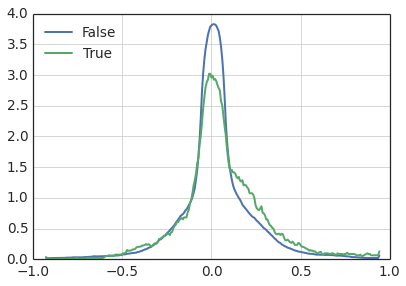

In [67]:
rr = np.log2(dm_cell.CD4T_mean / dm_cell.CD8T_mean).clip(-1.,1.)
draw_dist(rr * ss, hiv_bh.ix[ti(hla_region)])

In [68]:
anova(hla_region, rr)

F    3.19e+02
p    2.73e-71
dtype: float64

In [69]:
pearson_pandas(corr_with_cd4_m.rho, rr)

rho   -0.00
p      0.48
dtype: float64

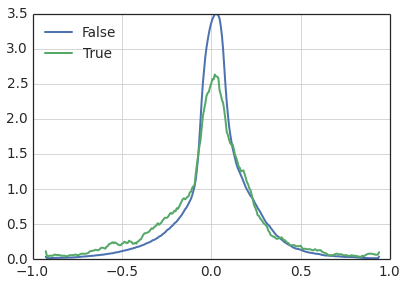

In [70]:
draw_dist(rr, corr_with_cd4_m.rho.abs() > .2)